In [1]:
import numpy as np
import pandas as pd
import math
import os
from datetime import timedelta, datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)

In [2]:
def get_tornado_data():
    '''
    get_tornado_data pulls in the original, unclean datafram as it comes from 
    the source; https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021
    '''
    # assign filename
    filename = 'tornado_df.csv'
    # assign csv as df
    df = pd.read_csv(filename, index_col=0)    
    return df

In [28]:
df = get_tornado_data()

In [29]:
df.head()

,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid
yr,,,,,,,,,,,,,
1950,1,3,1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130
1950,1,3,1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150
1950,1,3,1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10
1950,1,13,1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17
1950,1,25,1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67558 entries, 1950 to 2021
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mo      67558 non-null  int64  
 1   dy      67558 non-null  int64  
 2   date    67558 non-null  object 
 3   st      67558 non-null  object 
 4   mag     67558 non-null  int64  
 5   inj     67558 non-null  int64  
 6   fat     67558 non-null  int64  
 7   slat    67558 non-null  float64
 8   slon    67558 non-null  float64
 9   elat    67558 non-null  float64
 10  elon    67558 non-null  float64
 11  len     67558 non-null  float64
 12  wid     67558 non-null  int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 7.2+ MB


In [31]:
df.shape

(67558, 13)

Right away I can see I want to:
- convert mo/dy/date to timestamp
- change column names to promote easy reading

In [32]:
df.index = pd.to_datetime(df.date).sort_index()

In [33]:
df = df.drop(columns = ['mo', 'dy', 'date'])

In [34]:
df.shape

(67558, 10)

In [35]:
df.head()

,st,mag,inj,fat,slat,slon,elat,elon,len,wid
date,,,,,,,,,,
1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130
1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150
1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10
1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17
1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100


In [36]:
df = df.rename(columns = {"st": "state", "mag": "ef", "inj": "injuries", 
                     "fat": "fatalities", "slat": "s_lat", "slon": "s_lon",
                     "elat": "e_lat", "elon": "e_lon", "len": "length", 
                     "wid": "width"})

In [37]:
df.head(1)

,state,ef,injuries,fatalities,s_lat,s_lon,e_lat,e_lon,length,width
date,,,,,,,,,,
1950-01-03,IL,3,3,0,39.1,-89.3,39.12,-89.23,3.6,130


In [38]:
df.describe()

,ef,injuries,fatalities,s_lat,s_lon,e_lat,e_lon,length,width
count,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000,67558.000000
mean,0.691273,1.437876,0.090470,37.142412,-92.784618,22.730695,-56.245590,3.478340,106.577030
std,1.283375,18.263956,1.484106,5.093979,8.689103,18.588638,45.489157,8.278775,205.802676
min,-9.000000,0.000000,0.000000,17.721200,-163.530000,0.000000,-163.530000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,33.220000,-98.450000,0.000000,-94.709800,0.100000,20.000000
50%,1.000000,0.000000,0.000000,37.030000,-93.600000,32.480000,-84.420000,0.800000,50.000000
75%,1.000000,0.000000,0.000000,40.930000,-86.730000,38.610000,0.000000,3.130000,100.000000
max,5.000000,1740.000000,158.000000,61.020000,-64.715100,61.020000,0.000000,234.700000,4576.000000


In [39]:
for col in df:
    print((col), (df[(col)] == 0).sum())

state 0
ef 31375
injuries 59869
fatalities 65999
s_lat 0
s_lon 0
e_lat 26363
e_lon 26363
length 123
width 473


In [40]:
df['cas_per_mile'] = df.apply(
    lambda x: (x['injuries'] + x['fatalities']) / x['length'] if (
        x['length'] != 0) else 0, axis=1)

In [41]:
df.head()

,state,ef,injuries,fatalities,s_lat,s_lon,e_lat,e_lon,length,width,cas_per_mile
date,,,,,,,,,,,
1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,0.833333
1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,0.315789
1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,10.000000
1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17,3.333333
1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100,0.000000


In [42]:
df['casualties'] = df.injuries + df.fatalities

In [43]:
df['cas_per_mile'] = round(df['cas_per_mile'],2)

In [44]:
df.head()

,state,ef,injuries,fatalities,s_lat,s_lon,e_lat,e_lon,length,width,cas_per_mile,casualties
date,,,,,,,,,,,,
1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,0.83,3
1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,0.32,3
1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,10.00,1
1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17,3.33,2
1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100,0.00,0


In [45]:
df_by_year = df.resample('Y').agg({
    'injuries': 'sum',
    'fatalities': 'sum',
    'length': 'mean',
    'width': 'mean',
    'casualties': 'sum',
    'cas_per_mile': 'mean'
})

In [46]:
df_by_year

,injuries,fatalities,length,width,casualties,cas_per_mile
date,,,,,,
1950-12-31,659,70,6.414925,128.184080,729,1.795871
1951-12-31,524,34,4.640000,111.026923,558,2.654192
1952-12-31,1915,230,6.921667,159.141667,2145,12.367000
1953-12-31,5131,523,9.164133,144.836105,5654,3.294252
1954-12-31,715,36,5.926545,128.107273,751,0.973436
...,...,...,...,...,...,...
2017-12-31,518,35,3.650574,191.418067,553,0.050301
2018-12-31,199,10,2.768606,152.186501,209,0.100924
2019-12-31,537,42,3.466394,192.148978,579,0.090013


<AxesSubplot:xlabel='date'>

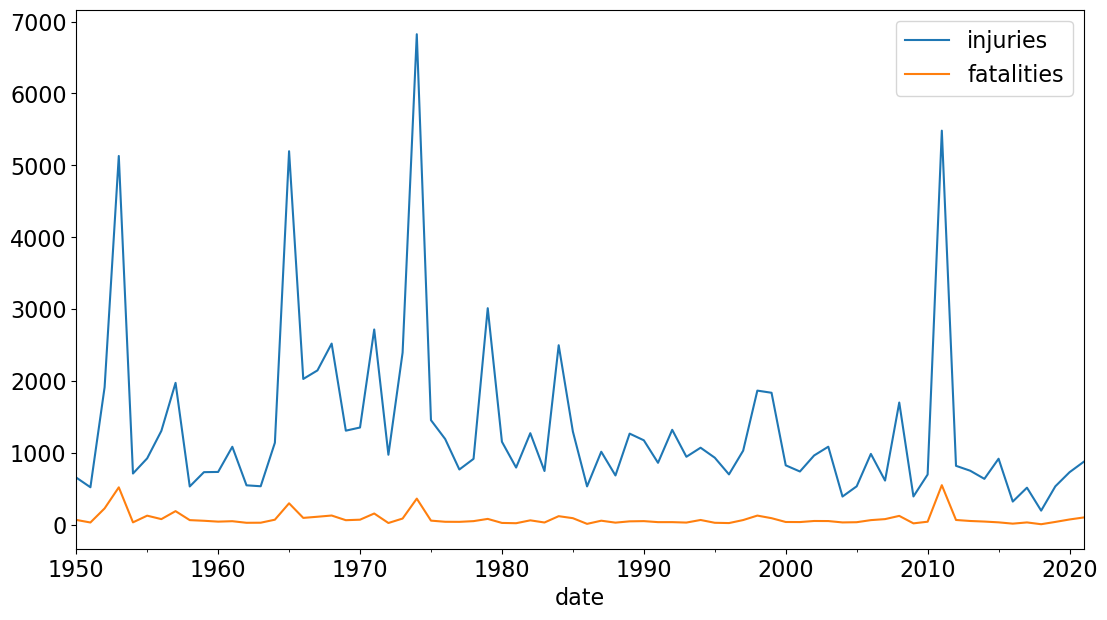

In [47]:
df_by_year[['injuries','fatalities']].plot()

<AxesSubplot:xlabel='date'>

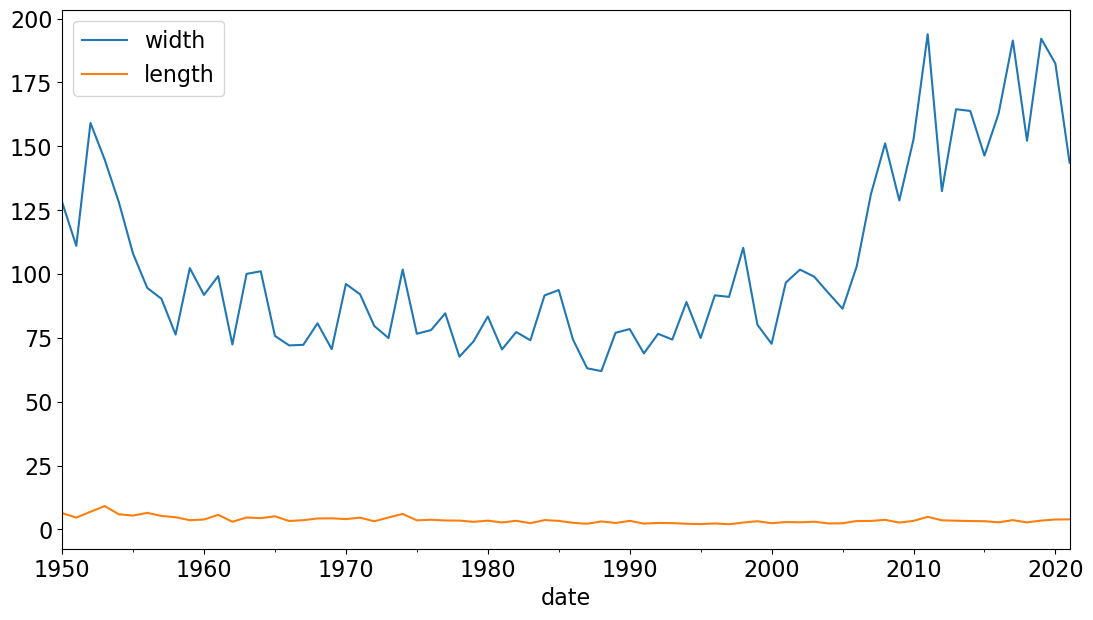

In [48]:
df_by_year[['width','length']].plot()